<a href="https://colab.research.google.com/github/richards-okiemute/Cars-Miles-Per-Gallon-Prediction-Using-SparkML/blob/main/Cars_Miles_Per_Gallon_Prediction_Using_SparkML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip3 install pyspark==3.1.2
!pip install findspark
import findspark
findspark.init()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212.4 MB 67 kB/s 
     |████████████████████████████████| 198 kB 21.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880769 sha256=91b40e22848ff002dcad13b1a32dbdbb4d52125c780024f56256705961daa55f
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Pandas is a popular data science package for Python. We will use Pandas to load a CSV file from disc to a pandas dataframe in memory.
import pandas as pd
import matplotlib.pyplot as plt
# pyspark is the Spark API for Python. In this lab, we use pyspark to initialize the spark context. 
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

# **Create and initialize the Spark session needed to load the dataframes and operate on it**

In [5]:
# Creating a spark context class
sc = SparkContext()

# Creating a spark session
spark = SparkSession \
    .builder \
    .appName("Python Spark DataFrames basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# Initialize Spark session

In [6]:
spark

## **Importing Spark ML libraries**

We will important four (4) import spark libraries to use in propcessing, statistical analysis, and prediction.



**Feature library:**
VectorAssembler(): This function is used to create feature vectors from dataframes/raw data. These feature vectors are required to train a ML model or perform any statistical operations.

---


**Stat library:**
Correlation(): This function is from the statistics library within SparkML. This function is used to calculate correlation between feature vectors.

---

**Feature library:** 
Normalized(): This function is used to normalize features. Normalizing features leads to better ML model convergence and training results.

---

**Regression Library:**
 LinearRegression(): This function is used to create a Linear Regression model and train it.

 ---

In [7]:
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression

# **Loading the data and Creating Feature Vectors**

Pandas will be used for loading CSV data into a DataFrame for Spark analysis

In [73]:
# Read the file using `read_csv` function in pandas
cars = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-BD0225EN-SkillsNetwork/labs/data/cars.csv')
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [75]:
cars2 = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-BD0225EN-SkillsNetwork/labs/data/cars2.csv', header=None, names=["mpg", "hp", "weight"])
cars2.head()

,mpg,hp,weight
0,18.0,130.0,3504.0
1,15.0,165.0,3693.0
2,18.0,150.0,3436.0
3,16.0,150.0,3433.0
4,17.0,140.0,3449.0


In [10]:
cars2.head()

,mpg,hp,weight
0,18.0,130.0,3504.0
1,15.0,165.0,3693.0
2,18.0,150.0,3436.0
3,16.0,150.0,3433.0
4,17.0,140.0,3449.0


In [11]:
cars2.describe()

,mpg,hp,weight
count,392.000000,392.000000,392.000000
mean,23.445918,104.469388,2977.584184
std,7.805007,38.491160,849.402560
min,9.000000,46.000000,1613.000000
25%,17.000000,75.000000,2225.250000
50%,22.750000,93.500000,2803.500000
75%,29.000000,126.000000,3614.750000
max,46.600000,230.000000,5140.000000


In [12]:
cars2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mpg     392 non-null    float64
 1   hp      392 non-null    float64
 2   weight  392 non-null    float64
dtypes: float64(3)
memory usage: 9.3 KB


# **Loading data into a Spark DataFrame**

In [13]:
# Data are loaded into Spark DataFrames using the `createDataFrame` function to load the data into a spark dataframe
sdf = spark.createDataFrame(cars2)

In [14]:
sdf.printSchema() #checking the schema of the dataframe

root
 |-- mpg: double (nullable = true)
 |-- hp: double (nullable = true)
 |-- weight: double (nullable = true)



# **Converting data frame columns into feature vectors**
hp - feature

weight - feature

mpg - target label

The VectorAssembler() function will be used to convert the dataframe columns into feature vectors.

In [15]:
featurevectors = VectorAssembler(inputCols=["hp", "weight"],outputCol="features")

output = featurevectors.transform(sdf).select('features','mpg')

### **Splitting the data into 75% training data and 25% test data**

In [16]:
train, test = output.randomSplit([.75,.25])

## **Performing Basic stats and feature engineering**

We will explore the correlation between feature vectors and normalize the features

---

**Correlation:**

Spark ML has inbuilt Correlation function as part of the Stat library. We use the correlation function to determine the different types of correlation between the 2 features - "hp" and "weight".

---

In [17]:
r1 = Correlation.corr(train, "features").head()
r1

Row(pearson(features)=DenseMatrix(2, 2, [1.0, 0.8638, 0.8638, 1.0], False))

In [18]:
r2 = Correlation.corr(train, "features", "spearman").head()
print("Spearman correlation matrix:\n\n" + str(r2[0]))

Spearman correlation matrix:

DenseMatrix([[1.        , 0.88281086],
             [0.88281086, 1.        ]])


We can see that there is 0.88 (88%) correlation between the feature vectors.

### **Visualizing the correlated feature vectors.**

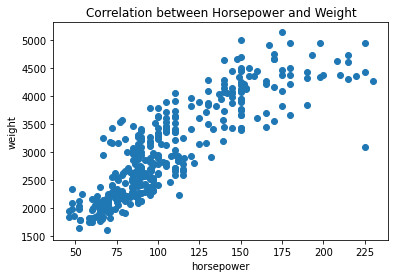

In [19]:
plt.figure()
plt.scatter(cars2["hp"], cars2["weight"])
plt.xlabel("horsepower")
plt.ylabel("weight")
plt.title("Correlation between Horsepower and Weight")
plt.show()

## **Normalization**

Normalization of feature vectors is very important in model training and ensuring quick convergence.

In [28]:
normalizer = Normalizer(inputCol="features", outputCol="features_normalized", p=1.0)
train_norm = normalizer.transform(train)
print("Normalized using L^1 normalization\n")
train_norm.show(10, truncate=False)

Normalized using L^1 normalization

+-------------+----+-----------------------------------------+
|features     |mpg |features_normalized                      |
+-------------+----+-----------------------------------------+
|[46.0,1835.0]|26.0|[0.024455077086656035,0.9755449229133439]|
|[46.0,1950.0]|26.0|[0.023046092184368736,0.9769539078156313]|
|[52.0,1649.0]|31.0|[0.030570252792475015,0.969429747207525] |
|[53.0,1795.0]|33.0|[0.02867965367965368,0.9713203463203464] |
|[54.0,2254.0]|23.0|[0.02339688041594454,0.9766031195840554] |
|[60.0,1834.0]|27.0|[0.03167898627243928,0.9683210137275607] |
|[61.0,2003.0]|32.0|[0.029554263565891473,0.9704457364341085]|
|[65.0,1773.0]|31.0|[0.03536452665941241,0.9646354733405876] |
|[67.0,1950.0]|31.0|[0.033217649975210706,0.9667823500247893]|
|[67.0,1963.0]|26.0|[0.03300492610837438,0.9669950738916256] |
+-------------+----+-----------------------------------------+
only showing top 10 rows



## **Standard Scaling**

Standardizing a dataset involves rescaling the distribution of values so that the mean of observed values is 0 and the standard deviation is 1

In [33]:
#Training dataset

standard_scaler = StandardScaler(inputCol="features", outputCol="features_scaled")
train_model = standard_scaler.fit(train)
train_scaled = train_model.transform(train)
print('Standardazied Training dataset\n')
train_scaled.show(10, truncate=False)

Standardazied Training dataset

+-------------+----+---------------------------------------+
|features     |mpg |features_scaled                        |
+-------------+----+---------------------------------------+
|[46.0,1835.0]|26.0|[1.2108815476755084,2.21088838308851]  |
|[46.0,1950.0]|26.0|[1.2108815476755084,2.3494454207207602]|
|[52.0,1649.0]|31.0|[1.3688226191114443,1.9867874352659145]|
|[53.0,1795.0]|33.0|[1.3951461310174336,2.162694630868597] |
|[54.0,2254.0]|23.0|[1.4214696429234228,2.7157179375920992]|
|[60.0,1834.0]|27.0|[1.5794107143593588,2.2096835392830125]|
|[61.0,2003.0]|32.0|[1.605734226265348,2.413302142412145]  |
|[65.0,1773.0]|31.0|[1.7110282738893052,2.136188067147645] |
|[67.0,1950.0]|31.0|[1.763675297701284,2.3494454207207602] |
|[67.0,1963.0]|26.0|[1.763675297701284,2.365108390192232]  |
+-------------+----+---------------------------------------+
only showing top 10 rows



In [32]:
#Test Dataset

test_scaled = train_model.transform(test)
print('Standardazied Test dataset\n')
test_scaled.show(10, truncate=False)

Standardazied Test dataset

+-------------+----+---------------------------------------+
|features     |mpg |features_scaled                        |
+-------------+----+---------------------------------------+
|[49.0,1867.0]|29.0|[1.2898520833934763,2.2494433848644406]|
|[52.0,2035.0]|29.0|[1.3688226191114443,2.451857144188075] |
|[60.0,2164.0]|24.5|[1.5794107143593588,2.6072819950972947]|
|[65.0,1836.0]|32.0|[1.7110282738893052,2.212093226894008] |
|[69.0,1613.0]|35.0|[1.8163223215132624,1.943413058267993] |
|[72.0,2401.0]|21.0|[1.8952928572312304,2.8928299770002797]|
|[72.0,3158.0]|15.0|[1.8952928572312304,3.8048967377621334]|
|[75.0,2108.0]|24.0|[1.9742633929491984,2.5398107419894167]|
|[75.0,2542.0]|25.0|[1.9742633929491984,3.062712953575473] |
|[80.0,2164.0]|28.0|[2.105880952479145,2.6072819950972947] |
+-------------+----+---------------------------------------+
only showing top 10 rows



### **Building and Training a Linear Regression Model**

## **Creating and Training the Linear Regression model**

We will create the model using the LinearRegression() class and train using the fit() function.

In [40]:
# Create a LR model
lrReg = LinearRegression(featuresCol='features_scaled', labelCol='mpg', maxIter=100)

# Fit the model
lrReg_Model = lrReg.fit(train_scaled)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrReg_Model.coefficients))
print("Intercept: %s" % str(lrReg_Model.intercept))

# Summarize the model over the training set and print out some metrics
training_output = lrReg_Model.summary
print("RMSE: %f" % training_output.rootMeanSquaredError)
print("R-squared: %f" % training_output.r2)

Coefficients: [-1.823355708740466,-4.980381752859592]
Intercept: 46.27290062172909
RMSE: 4.222329
R-squared: 0.710104


In [63]:
print("The RMSE (Root mean squared error) of the trained model is", round(training_output.rootMeanSquaredError,3),  "\nThis means that our model predicts the mpg with an average error of ", round(training_output.rootMeanSquaredError,1), " units.")

The RMSE (Root mean squared error) of the trained model is 4.222 
This means that our model predicts the mpg with an average error of  4.2  units.


### **Predicting on new data**

After training the model, we can use transform() on new unseen data (for eg. the test data) to generate predictions. In the below cell, notice the "prediction" column that contains the predicted "mpg".

In [68]:
lrReg_Model.transform(test_scaled).show(30)

+--------------+----+--------------------+------------------+
|      features| mpg|     features_scaled|        prediction|
+--------------+----+--------------------+------------------+
| [49.0,1867.0]|29.0|[1.28985208339347...| 32.71795467397324|
| [52.0,2035.0]|29.0|[1.36882261911144...|31.565865503386444|
| [60.0,2164.0]|24.5|[1.57941071435935...| 30.40781340631418|
| [65.0,1836.0]|32.0|[1.71102827388930...|32.136018707869475|
| [69.0,1613.0]|35.0|[1.81632232151326...|33.282160014218185|
| [72.0,2401.0]|21.0|[1.89529285723123...|28.409709939184076|
| [72.0,3158.0]|15.0|[1.89529285723123...|23.867269286495983|
| [75.0,2108.0]|24.0|[1.97426339294919...| 30.02388911851698|
| [75.0,2542.0]|25.0|[1.97426339294919...|27.419636485403856|
| [80.0,2164.0]|28.0|[2.10588095247914...|29.447870892156516|
| [80.0,2451.0]|26.0|[2.10588095247914...|27.725703828323645|
| [85.0,2310.0]|19.0|[2.23749851200909...|28.331800276440795|
| [88.0,2100.0]|27.0|[2.31646904772705...|29.447931141146075|
| [88.0,